In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rvseg import patient, model, loss
from rvseg import dataset

%matplotlib inline

Using TensorFlow backend.


In [2]:
def sorensen_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return 2*intersection / (np.sum(y_true) + np.sum(y_pred))

def jaccard(y_true, y_pred):
    intersection = np.sum(y_true & y_pred)
    union = np.sum(y_true | y_pred)
    return intersection / union

## Train and Validation Performance

In [3]:
# load saved model weights
datadir = "/home/paperspace/Developer/work/rvsc/"
weight_file = datadir + "eaug-norm/weights-487-0.9933.hdf5"

m = model.u_net(height=216, width=256, maps=1,
                features=32, depth=3, classes=2,
                temperature=1.0,
                padding='same',
                batchnorm=False,
                dropout=0.0)
m.load_weights(weight_file)

In [5]:
# It is CRUCIAL that this seed is identical to the value used
# in the config file used to train the model -- otherwise the
# train-val split won't match the training data.
seed = 0

data_dir = "/home/paperspace/Developer/datasets/rvsc/TrainingSet/"
batch_size = 32
validation_split = 0.2
classes = "inner"
augment_training = True
augment_validation = False
augmentation_args = {
    'rotation_range': 180,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.05,
    'fill_mode' : "nearest",
    'alpha': 500,
    'sigma': 20,
}

train_generator, train_steps_per_epoch, \
    val_generator, val_steps_per_epoch = dataset.create_generators(
        data_dir, batch_size,
        validation_split=validation_split,
        mask=classes,
        shuffle_train_val=True,
        shuffle=True,
        seed=seed,
        normalize_images=True,
        augment_training=augment_training,
        augment_validation=augment_validation,
        augmentation_args=augmentation_args)

In [21]:
def compute_statistics(generator, steps_per_epoch):
    dices = []
    jaccards = []
    for i in range(steps_per_epoch):
        images, masks_true = next(generator)
        masks_pred = m.predict(images)
        for mask_true, mask_pred in zip(masks_true, masks_pred):
            y_true = mask_true[:,:,1].astype('uint8')
            y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
            dices.append(sorensen_dice(y_true, y_pred))
            jaccards.append(jaccard(y_true, y_pred))
    print("Dice:    {:.2f} ({:.2f})".format(np.mean(dices), np.std(dices)))
    print("Jaccard: {:.2f} ({:.2f})".format(np.mean(jaccards), np.std(jaccards)))

In [22]:
print("Training Set:")
compute_statistics(train_generator, train_steps_per_epoch)
print("Validation Set:")
compute_statistics(val_generator, val_steps_per_epoch)

Training Set:
Dice:    0.87 (0.15)
Jaccard: 0.80 (0.17)
Validation Set:
Dice:    0.82 (0.24)
Jaccard: 0.74 (0.24)


## Visualize predicted masks

In [ ]:
def gridplot(images, masks_true, masks_pred):
    rows = len(images)
    cols = 3
    plt.figure(figsize=(12,3.75*rows))
    i = 1
    for image,mask_true, mask_pred in zip(images, masks_true, masks_pred):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(mask_pred[:,:,1], cmap=plt.cm.gray)
        plt.subplot(rows, cols, i+1)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        plt.imshow(np.round(mask_pred[:,:,1]), cmap=plt.cm.gray, alpha=0.3)
        plt.subplot(rows, cols, i+2)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        plt.imshow(np.round(mask_true[:,:,1]), cmap=plt.cm.gray, alpha=0.3)
        i += 3

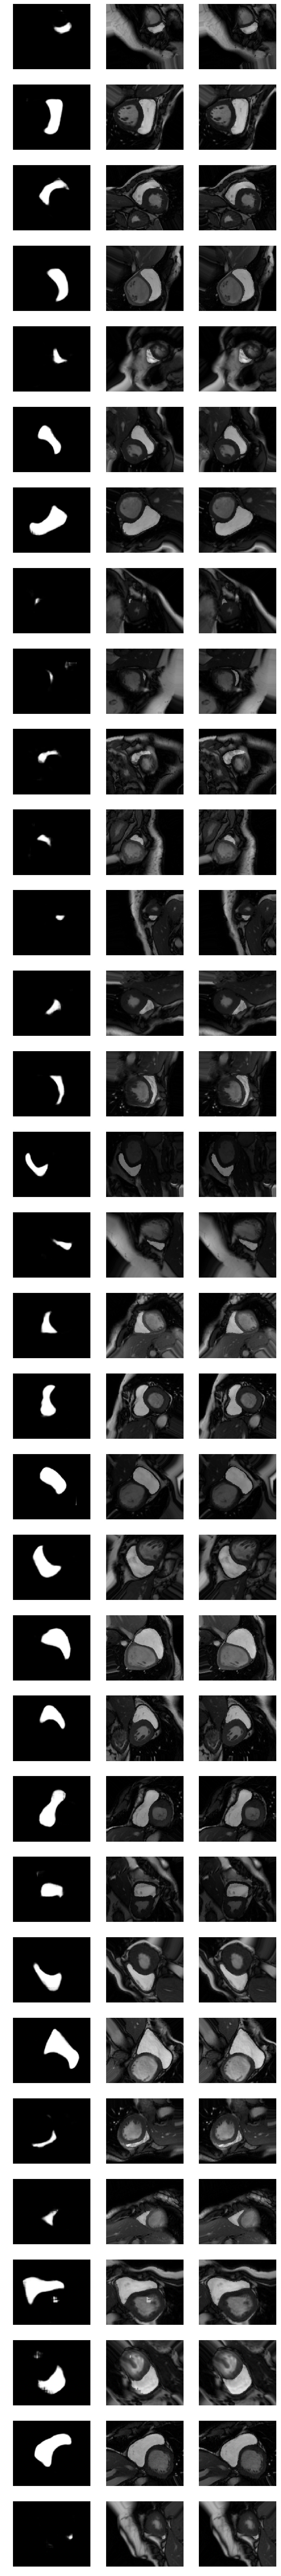

In [18]:
# Visualize predictions on training set

images, masks_true = next(train_generator)
masks_pred = m.predict(images)

n = len(images)
gridplot(images[:n], masks_true[:n], masks_pred[:n])

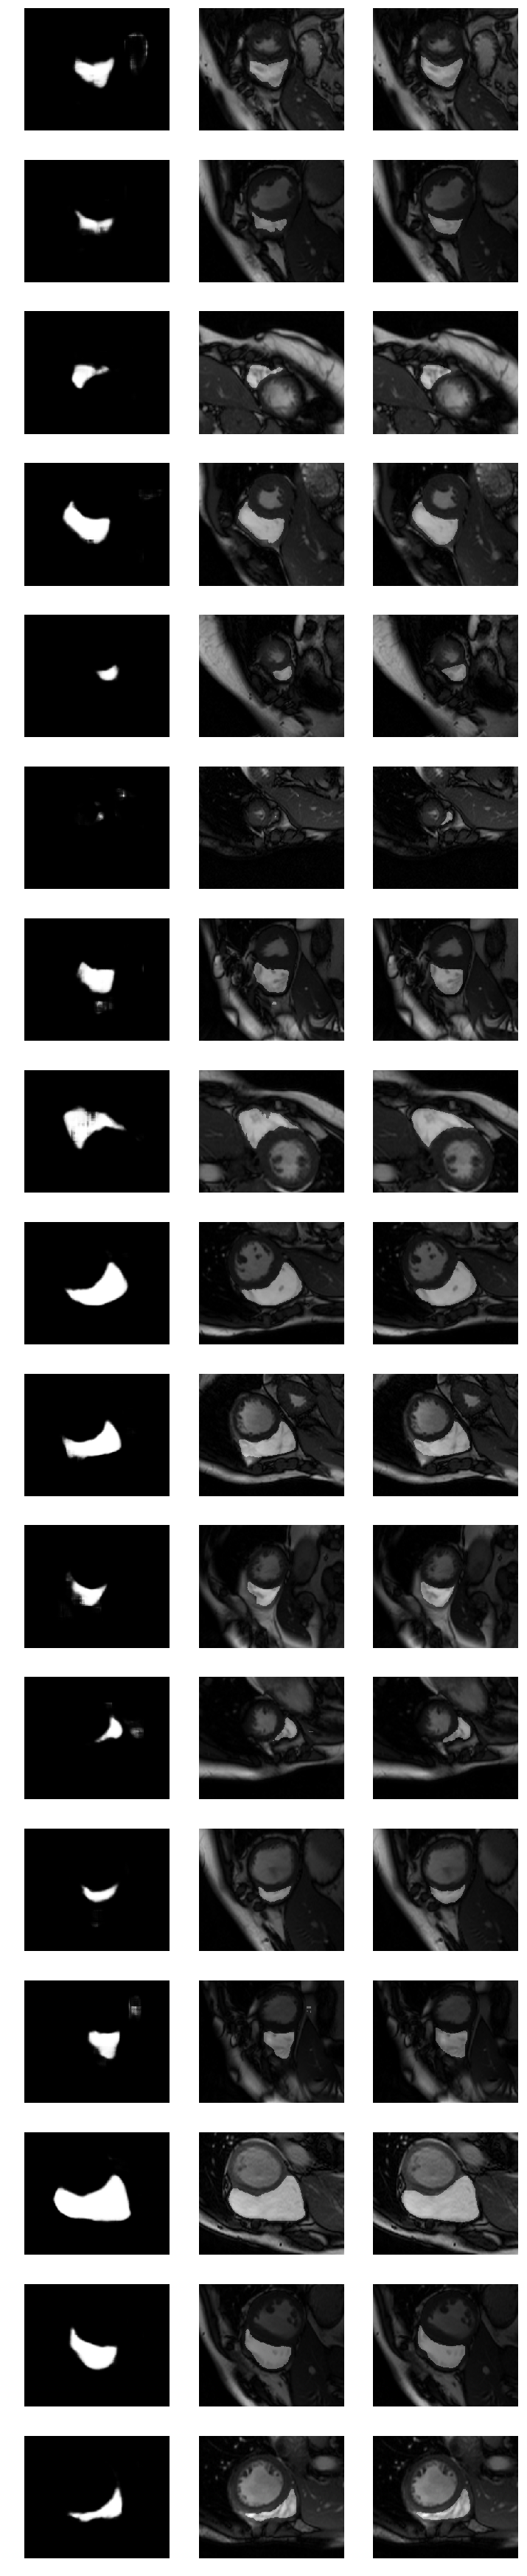

In [20]:
# Visualize predictions on validation set

images, masks_true = next(val_generator)
masks_pred = m.predict(images)

n = len(images)
gridplot(images[:n], masks_true[:n], masks_pred[:n])

# Peek at Test Data

In [13]:
# load test data

data_dir = "/home/paperspace/Developer/datasets/rvsc/Test1Set/patient19/"
p = patient.PatientData(data_dir)
images = np.asarray(p.all_images, dtype="float64")[:,:,:,None]
dataset.normalize(images, axis=(1,2))

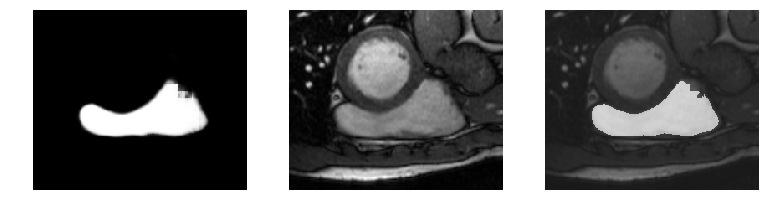

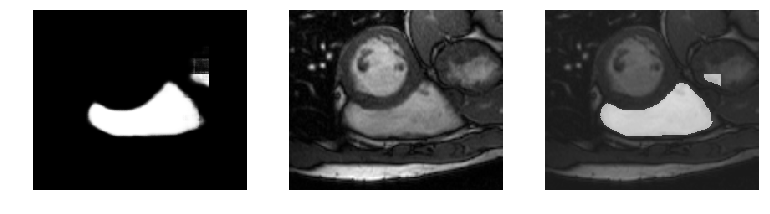

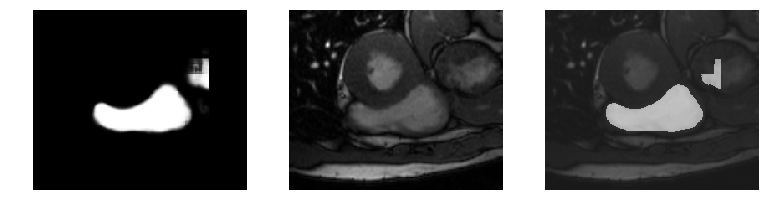

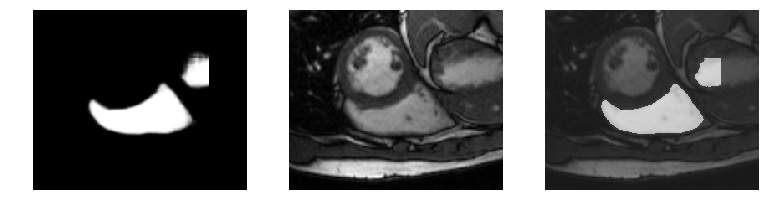

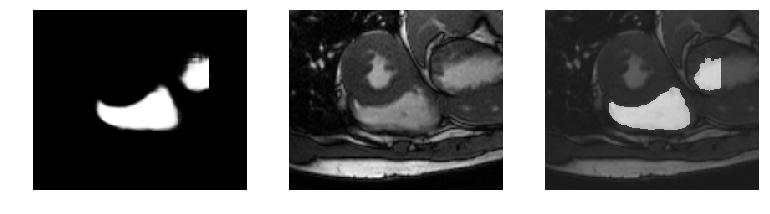

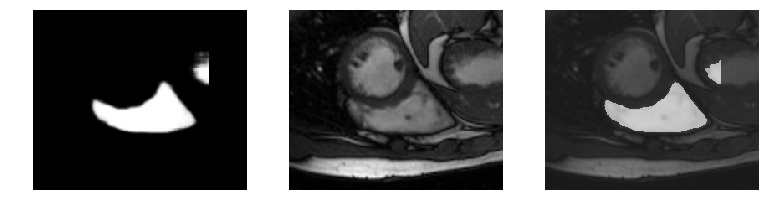

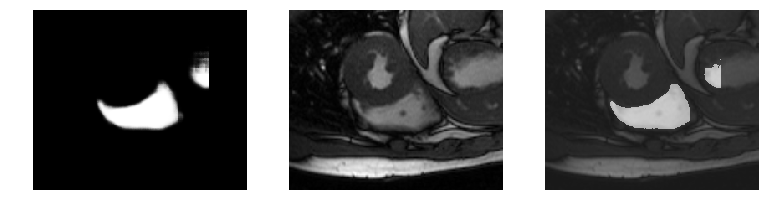

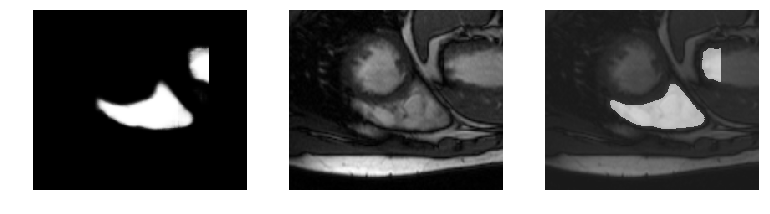

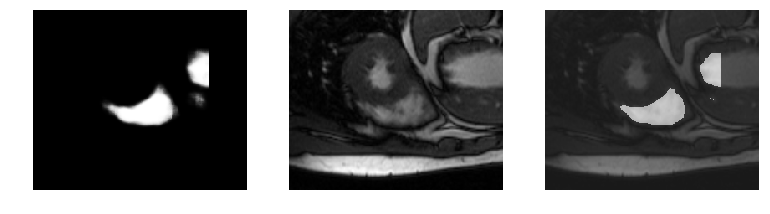

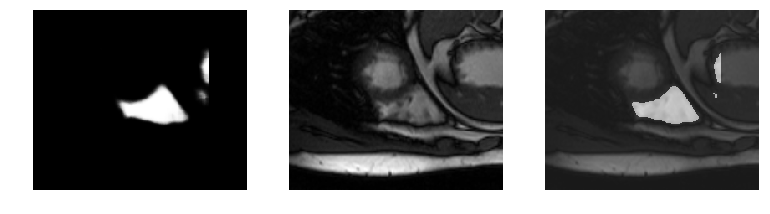

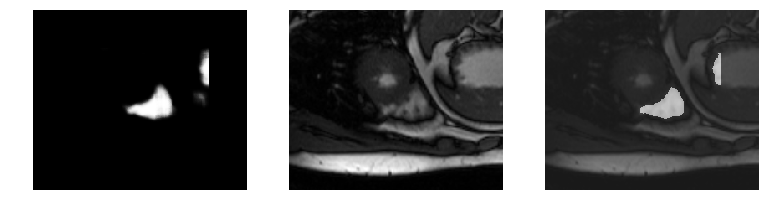

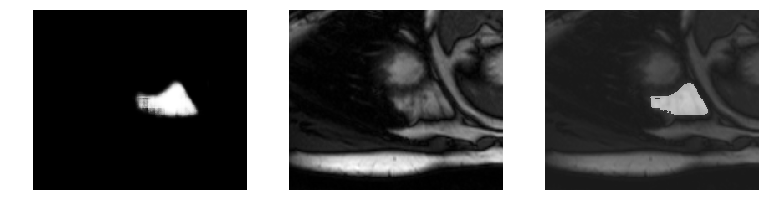

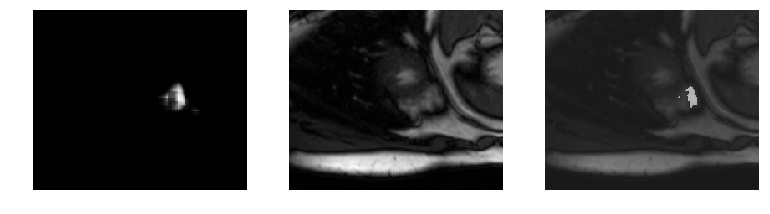

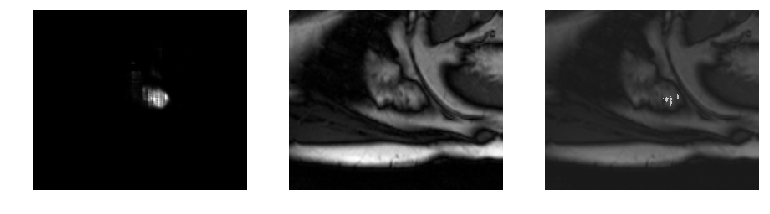

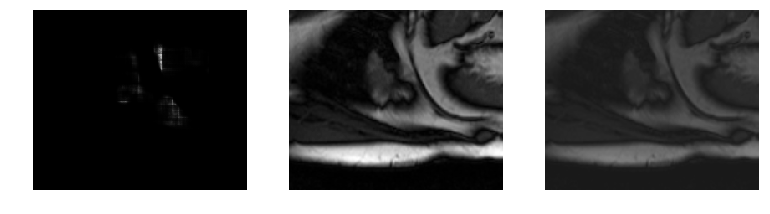

In [14]:
frames = [80, 100, 108, 128, 140, 148, 160, 168, 180, 188, 200]
frames = [40, 60, 80, 87, 100, 107, 120, 127, 140, 147, 160, 167, 180, 187, 200, 207]
frames = [80, 100, 106, 120, 126, 140, 146, 160, 166, 180, 186, 200, 206, 220, 226]

masks = m.predict(images)

for n in frames:
    plt.figure(figsize=(13,5))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(masks[n,:,:,1], cmap=plt.cm.gray)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(p.all_images[n], cmap=plt.cm.gray)
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(p.all_images[n], cmap=plt.cm.gray, alpha=0.8)
    plt.imshow(np.round(masks[n,:,:,1]), cmap=plt.cm.gray, alpha=0.5)